# Mini Project - Spam Email Classifier

### Importing libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the data

In [4]:
data = pd.read_csv("Datasets/SMSSpamCollection", sep='\t', header=None, names = ['label', 'sms'])
data.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploring the dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
data.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


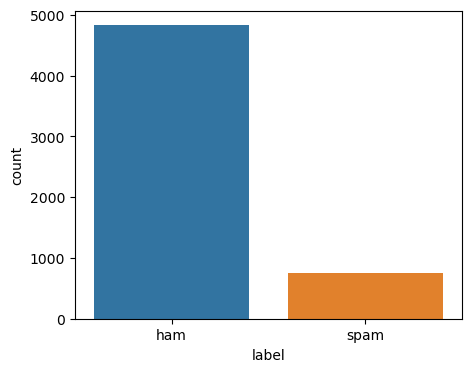

In [9]:
plt.figure(figsize = (5,4))
sns.countplot(x = 'label', data = data);

### Cleaning the data